## Data Preparation for machine learning
### Principal Component Analysis


### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
import plotly.express as px

ModuleNotFoundError: No module named 'pyspark'

### Intiate spark session

In [2]:
# Intiate spark session
spark = SparkSession.builder.appName("Clustering").getOrCreate()

###  Import dataframe

In [3]:
# Import dataframe
application_df = spark.read.csv("application_data_prepared.csv",
                                inferSchema=True,header=True)

### Print schema

In [4]:
# Print Schema
application_df.printSchema()

root
 |-- sk_id_curr: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- name_contract_type: string (nullable = true)
 |-- code_gender: string (nullable = true)
 |-- flag_own_car: string (nullable = true)
 |-- flag_own_realty: string (nullable = true)
 |-- cnt_children: integer (nullable = true)
 |-- amt_income_total: double (nullable = true)
 |-- amt_credit: double (nullable = true)
 |-- amt_annuity: double (nullable = true)
 |-- amt_goods_price: double (nullable = true)
 |-- name_type_suite: string (nullable = true)
 |-- name_income_type: string (nullable = true)
 |-- name_education_type: string (nullable = true)
 |-- name_family_status: string (nullable = true)
 |-- name_housing_type: string (nullable = true)
 |-- region_population_relative: double (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- days_registration: double (nullable = true)
 |-- days_id_publish: integer (nullable = true)
 |-- flag_emp_p

### Categorical and Numerical Features

In [5]:
# Target feature
target_feature = "target"

# Categorical features
categorical_features =  ['name_contract_type', 'code_gender', 'flag_own_car',
       'flag_own_realty', 'name_type_suite', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'occupation_type', 'weekday_appr_process_start',
       'organization_type']


# Numerical features
numerical_features   = [ 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'amt_goods_price', 'region_population_relative',
       'days_birth', 'days_employed', 'days_registration',
       'days_id_publish', 'flag_emp_phone', 'flag_work_phone',
       'flag_phone', 'cnt_fam_members', 'region_rating_client',
       'region_rating_client_w_city', 'hour_appr_process_start',
       'reg_region_not_live_region', 'reg_region_not_work_region',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city', 'ext_source_2', 'ext_source_3',
       'obs_30_cnt_social_circle', 'def_30_cnt_social_circle',
       'obs_60_cnt_social_circle', 'def_60_cnt_social_circle',
       'days_last_phone_change', 'flag_document_3', 'flag_document_6',
       'flag_document_8', 'flag_document_11', 'flag_document_13',
       'flag_document_14', 'flag_document_15', 'flag_document_16',
       'flag_document_18', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year', 'own_car_age',
       'bu_credit_active_active', 'bu_credit_active_closed',
       'bu_credit_active_sold', 'bu_credit_currency_currency_1',
       'bu_credit_currency_currency_2', 'bu_credit_currency_currency_3',
       'bu_credit_type_another_type_of_loan', 'bu_credit_type_car_loan',
       'bu_credit_type_consumer_credit', 'bu_credit_type_credit_card',
       'bu_credit_type_loan_for_business_development',
       'bu_credit_type_loan_for_working_capital_replenishment',
       'bu_credit_type_microloan', 'bu_credit_type_mortgage',
       'bu_credit_type_unknown_type_of_loan', 'bu_prev_app_count',
       'hc_name_contract_status_approved',
       'hc_name_contract_status_canceled',
       'hc_name_contract_status_refused',
       'hc_name_contract_status_unused_offer',
       'hc_code_reject_reason_client', 'hc_code_reject_reason_hc',
       'hc_code_reject_reason_limit', 'hc_code_reject_reason_sco',
       'hc_code_reject_reason_scofr', 'hc_code_reject_reason_system',
       'hc_code_reject_reason_verif', 'hc_code_reject_reason_xap',
       'hc_code_reject_reason_xna', 'hc_prev_app_count']


### Data preparation

In [6]:

# Encodes a string column of to a column of numerical values
indexer = StringIndexer(inputCols  = categorical_features,
                        outputCols = ["indexed_"+ i for i in categorical_features])

# String columns with two levels
indexed_cols = ['indexed_name_contract_type',
                'indexed_code_gender',
                'indexed_flag_own_car',
                'indexed_flag_own_realty']


# String columns with multiple levels
encode_cols  = [i for i in ["indexed_"+ i for i in categorical_features] 
                if i not in indexed_cols]


# Maps a categorical feature to new numerical 
encoder = OneHotEncoder(inputCols = encode_cols,
                        outputCols= ["encoded_"+ i for i in encode_cols])

# Output features of one hot encoder
encode_output_cols = ["encoded_"+ i for i in encode_cols]

# All predictor features
predictor_cols     = numerical_features + indexed_cols + encode_output_cols

# Combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols = predictor_cols,
                            outputCol = "features")

# normalizing each feature to have unit standard deviation and 
# centers the data with mean before scaling
scaler = StandardScaler(inputCol = "features",outputCol = "scaled_features",
                        withMean = True, withStd = True)

# Combine workflow 
pipeline_model = Pipeline(stages = [indexer,encoder,assembler,scaler])

#Output dataframe
pipeline_df = pipeline_model.fit(application_df).transform(application_df)
pipeline_df.select("scaled_features").show()


+--------------------+
|     scaled_features|
+--------------------+
|[-0.5885885111540...|
|[-0.5885885111540...|
|[-0.5885885111540...|
|[0.78421089560134...|
|[-0.5885885111540...|
|[-0.5885885111540...|
|[0.78421089560134...|
|[-0.5885885111540...|
|[-0.5885885111540...|
|[0.78421089560134...|
|[-0.5885885111540...|
|[-0.5885885111540...|
|[-0.5885885111540...|
|[0.78421089560134...|
|[0.78421089560134...|
|[0.78421089560134...|
|[-0.5885885111540...|
|[2.15701030235674...|
|[-0.5885885111540...|
|[0.78421089560134...|
+--------------------+
only showing top 20 rows



In [7]:
# feature names for scaled vector
import itertools

aft_enc = encode_output_cols
bef_enc = [i.replace('encoded_indexed_', '') for i in aft_enc]
result  = []
ls_name_pref = list(["suite_"] * 7 + ["income_"] * 4 + 
           ["education_"] * 4 + ["fam_"] * 4 +
           ["housing_"] * 5 + ["occupation_"] * 18+
           ["weekday_"] * 6 + ["organization_"] * 57)

for i,j in itertools.zip_longest(bef_enc,aft_enc):
    list_vals = list(pipeline_df.select(i,j).distinct().rdd.collectAsMap().keys())[:-1]
    result.append(pd.Series(list_vals))
    ls_name = list(itertools.chain(*(result)))
    ls_name_concat = list(pd.Series(ls_name_pref) + pd.Series(ls_name))
    list_of_columns = numerical_features + indexed_cols + ls_name_concat

### Principle Component Analysis (PCA)

In [47]:
# Fit PCA model with 184 principle components
pca = PCA(k = 184, inputCol = "scaled_features",
          outputCol= "pca_features")
pca_model = pca.fit(pipeline_df)
pca_df = pca_model.transform(pipeline_df)

### Scores

In [9]:
# Scores - transformed attribute values for each data point (PCs)
pca_df.select("pca_features").head()

Row(pca_features=DenseVector([-1.0198, -0.3572, -0.04, -2.4186, -1.1008, -0.5455, -5.1307, 0.3128, -1.5016, 2.1653, -1.2326, -0.6286, -0.0663, 0.2282, 0.0708, -1.4136, -1.5059, 1.3196, -2.0124, 1.7906, 3.2444, -1.109, -0.4094, -0.2849, -0.133, -0.57, -1.062, -1.6969, 0.5528, 1.7467, 0.4468, 1.3876, -0.7855, 0.9508, -0.1296, -0.1976, 1.4157, 0.599, -0.5866, -0.0713, 0.155, 0.5405, -0.239, 0.2206, -0.1815, 0.0665, -0.4469, 0.2875, 0.0673, -0.03, 0.1993, 0.2775, 0.0775, -0.5226, 0.4895, 0.1189, 0.6443, -0.349, -0.1223, 0.2473, -0.0966, -0.1853, 0.2222, -0.2431, -0.0987, -0.2131, -0.0542, 0.2476, 0.0414, -0.2147, -0.0587, 0.0534, -0.0339, -0.2689, -0.2199, -0.116, -0.1539, -0.0524, -0.0968, 0.2063, 0.0389, -0.0781, 0.0655, 0.0784, 0.0186, -0.0255, -0.1291, 0.0547, 0.0206, -0.0556, -0.018, -0.1295, -0.216, -0.1231, -0.2782, 0.1901, -0.1819, -0.309, -0.0239, 0.1303, -0.2534, -0.0628, 0.021, -0.1812, 0.6238, -0.1098, -0.2121, -0.1746, -0.2726, -0.8714, -0.3518, -0.3122, -0.1023, 0.6653, 0.267

### Loadings

In [167]:
pca_model.pc

DenseMatrix(184, 184, [-0.1439, -0.0992, -0.0645, -0.0845, -0.065, -0.0129, -0.2769, 0.1371, ..., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0)

In [168]:
# Loadings - weights of original attributes
loadings    = pca_model.pc.toArray()
loadings_df = pd.DataFrame(loadings,
                           columns =  ["PC_" + str(i) for i in range(1,185)])
loadings_df["feature_name"] = list_of_columns

Text(0.5, 1.0, 'Loadings for 10 principle components')

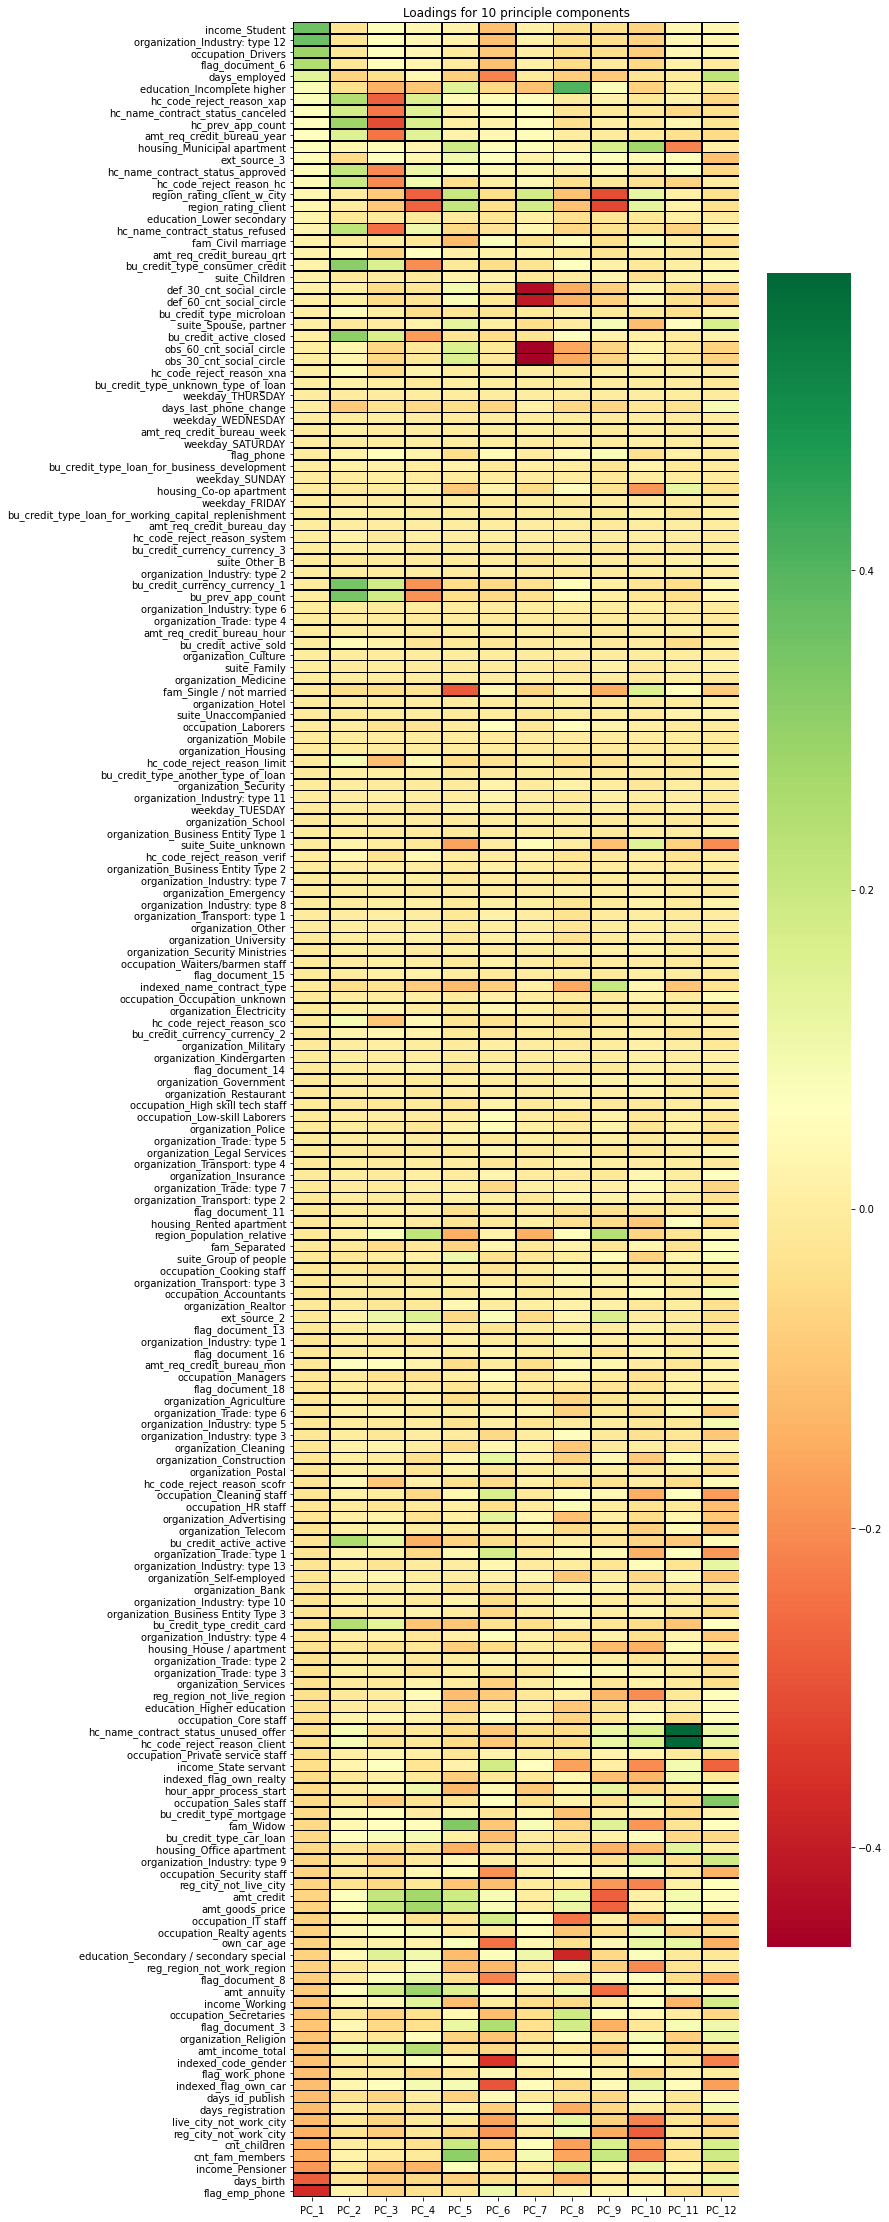

In [169]:
# plot loadings for first 10 components
plt.figure(figsize=(10,40))
loadings_hm = loadings_df[["PC_" + str(i) for i in range(1,13)]]
loadings_hm.index = loadings_df["feature_name"]
loadings_hm  = loadings_hm .sort_values(by = ["PC_1"],ascending =False)
sns.heatmap(loadings_hm ,cmap="RdYlGn",
            linewidth = .7,linecolor = "k")
plt.ylabel("")
plt.yticks()
plt.title("Loadings for 10 principle components")
#plt.savefig('/Users/pavan/Desktop/home-credit-default-risk/foo.png', bbox_inches='tight')


### Proportion of Explained Variance (PEV)

In [37]:
pca_model.explainedVariance

DenseVector([0.035, 0.0309, 0.0224, 0.02, 0.0157, 0.0144, 0.0133, 0.0127, 0.0124, 0.0112, 0.0108, 0.0106, 0.0103, 0.0098, 0.0091, 0.0088, 0.0084, 0.0082, 0.0079, 0.0076, 0.0075, 0.0075, 0.0074, 0.0072, 0.0072, 0.0071, 0.007, 0.007, 0.0067, 0.0066, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0064, 0.0063, 0.0063, 0.0062, 0.0062, 0.0061, 0.0061, 0.006, 0.006, 0.0059, 0.0059, 0.0058, 0.0058, 0.0058, 0.0058, 0.0057, 0.0057, 0.0057, 0.0057, 0.0057, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0051, 0.0051, 0.0051, 0.0051, 0.005, 0.005, 0.005, 0.005, 0.0049, 0.0049, 0.0049, 0.0048

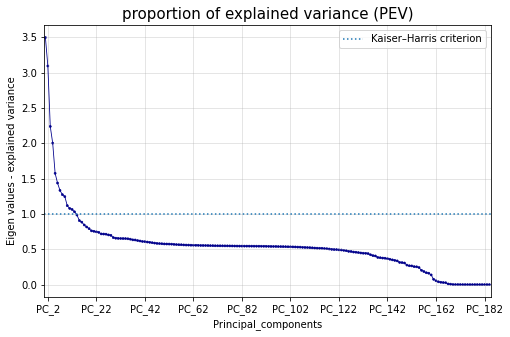

In [76]:
#  proportion of exaplained variance (PEV) 
exp_variance_val = 100*pca_model.explainedVariance.toArray()
exp_variance = pd.DataFrame({"Principal_components" : ["PC_" + str(i) for 
                                                           i in np.arange(1,185,1).tolist()],
                             "Explained_variance" : exp_variance_val})

# Plot PEV 
plt.figure(figsize = (8,5))
sns.pointplot(x = exp_variance["Principal_components"],
            y = exp_variance["Explained_variance"],
            color='darkblue',linewidth = 1,scale =.3,
            edgecolor = "black", ci=None)
plt.title("proportion of explained variance (PEV)").set_fontsize('15')
plt.ylabel("Eigen values - explained variance")
plt.axhline(1,linestyle = "dotted",label = "Kaiser–Harris criterion")
plt.xticks(np.arange(1,200,20),size = 10)
plt.grid(True,alpha = .4)
plt.legend()
plt.show()

### Cummulative value of PEV 

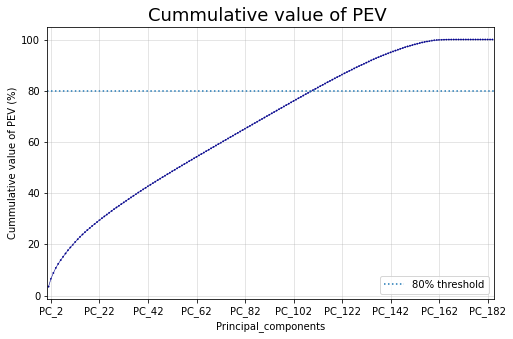

In [170]:
# Cummulative value of PEV 
cummulative_prop = pd.DataFrame({"Principal_components" : ["PC_" + str(i) for 
                                                           i in np.arange(1,185,1).tolist()],
                                 "Cummulative_PEV" : np.cumsum(exp_variance_val)})

# Plot PEV
plt.figure(figsize = (8,5))
sns.pointplot(x = cummulative_prop["Principal_components"],
              y = cummulative_prop["Cummulative_PEV"],scale=.2,
              color='darkblue', ci=None)
plt.title("Cummulative value of PEV ").set_fontsize('18')
plt.ylabel("Cummulative value of PEV (%)")
plt.axhline(y=80,linestyle = "dotted",label = "80% threshold")
plt.xticks(np.arange(1,200,20),size = 10)
plt.legend(loc = "lower right")
plt.grid(True,alpha = .4)
plt.show()

### Selecting optimal PCS's

In [171]:
number_of_pcs  = cummulative_prop[cummulative_prop["Cummulative_PEV"] < 80]
identified_pcs = number_of_pcs["Principal_components"].tolist()

,Principal_components,Cummulative_PEV
0,PC_1,3.495082
1,PC_2,6.587996
2,PC_3,8.825520
3,PC_4,10.827026
4,PC_5,12.401767
5,PC_6,13.838759
6,PC_7,15.172145
7,PC_8,16.445184
8,PC_9,17.690000
9,PC_10,18.807585


### Principle components and target variable

In [15]:
# create a dataframe with principle components and target variable
pc_df_pandas_sel = pca_df.select("pca_features").toPandas()
pc_df_pandas = (pc_df_pandas_sel["pca_features"].astype(str).str.replace("[","").str.replace("]","").str.split(",",expand=True))
pc_df_pandas.columns = ["PC_" + str(i) for i in np.arange(1,185,1).tolist()]
pc_df_pandas = pc_df_pandas[["PC_" + str(i) for i in np.arange(1,185,1).tolist()]].apply(pd.to_numeric)
pc_df_pandas["target"] = application_df.select("target").toPandas()

In [29]:
write_pc_df = pc_df_pandas[identified_pcs+ ["target"]]
write_pc_df.to_csv("pc_selected_df.csv")